<a href="https://colab.research.google.com/github/ANUSHKA3009SP/videointoframes/blob/main/Copy_of_videotoframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##EXTRACTING FRAMES FROM VIDEO

In [ ]:
#Read dataset
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mainPath = "/content/gdrive/My Drive/Colab Notebooks/Watershed/Tom and jerry.mp4" 

In [ ]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
#from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
#from keras.utils import np_utils
from skimage.transform import resize   # for resizing images

In [ ]:
count = 0
videoFile = mainPath
cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
frameRate = cap.get(5) #frame rate
x=1
while(cap.isOpened()):
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if (ret != True):
        break
    if (frameId % math.floor(frameRate) == 0):
        filename ="frame%d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()
print ("Done!")

Done!


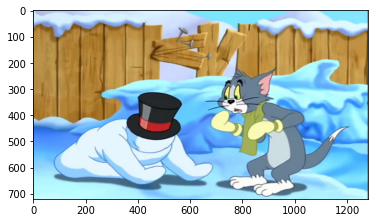

In [ ]:
img = plt.imread('frame60.jpg')   # reading image using its name
plt.imshow(img)

##Watershed on a frame

In [ ]:

import skimage
from skimage.feature import peak_local_max
from scipy import ndimage as ndi

import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

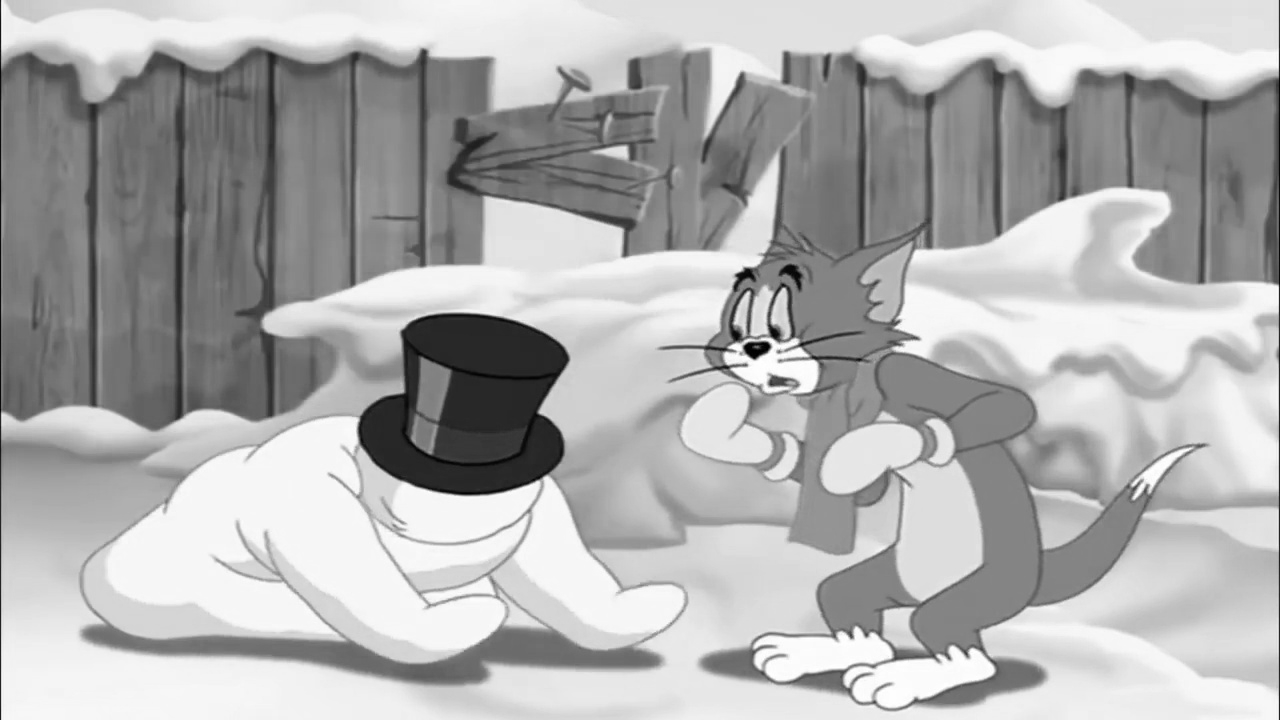

In [ ]:
#grey image + binary image using binary threshold
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#ret, thresh_img = cv2.threshold(gray, 120, 255, cv2.THRESH_BINARY)
#cv2_imshow(thresh_img)
cv2_imshow(gray)

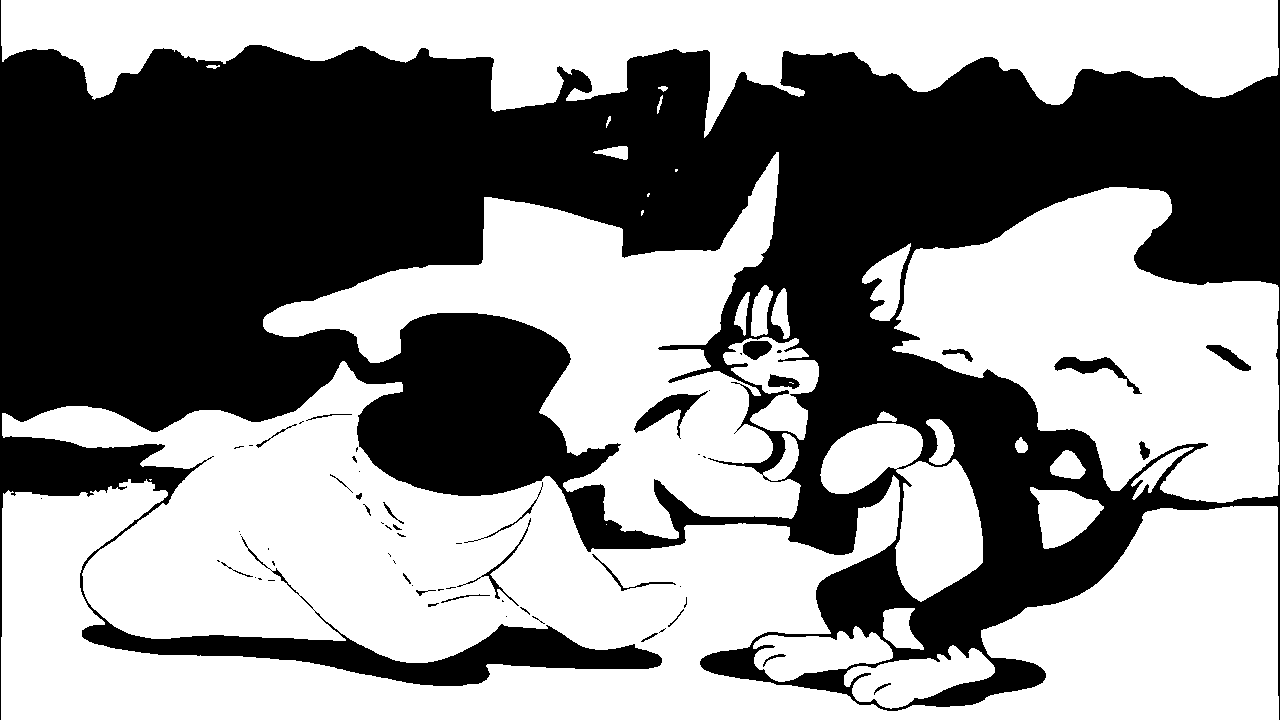

In [ ]:
blur = cv2.GaussianBlur(gray,(3,3),0)
(thresh, im_bw) = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

cv2_imshow(im_bw)

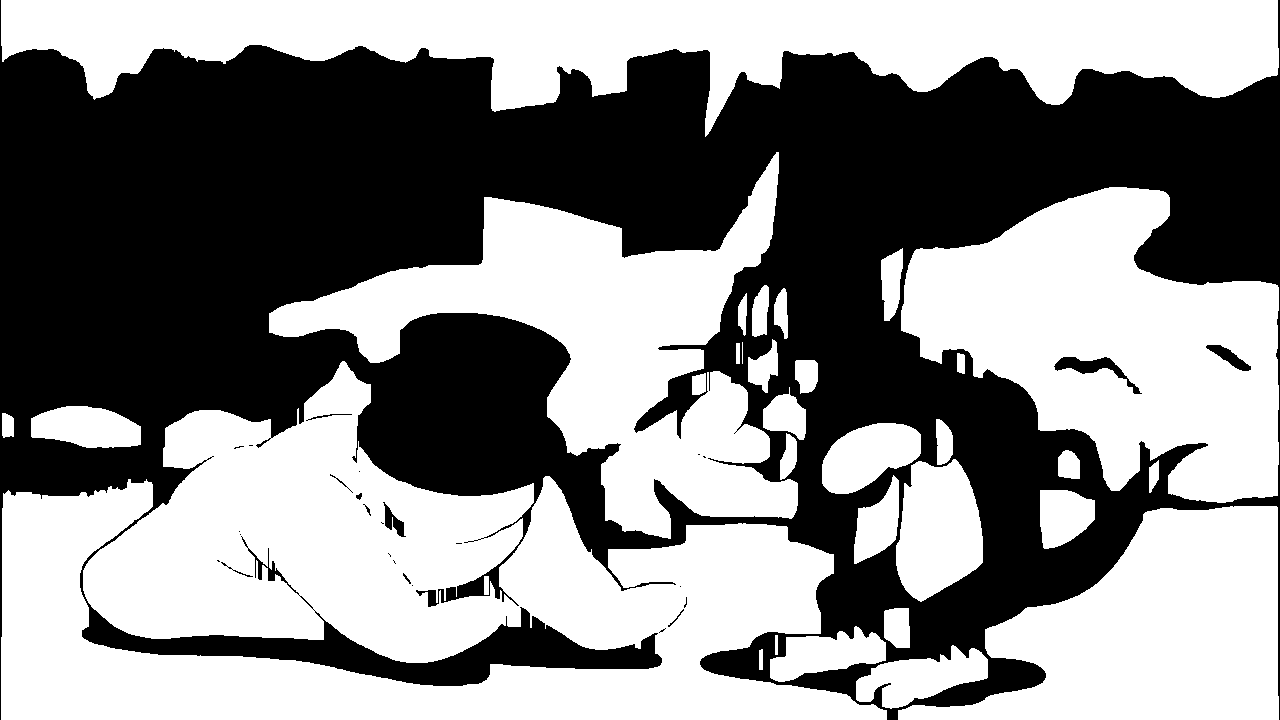

In [ ]:
# Noise removal
kernel = np.ones((3),np.uint8)
#opening_img = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel, iterations = 9)
opening_img = cv2.morphologyEx(im_bw, cv2.MORPH_OPEN, kernel, iterations = 9)

cv2_imshow(opening_img) 

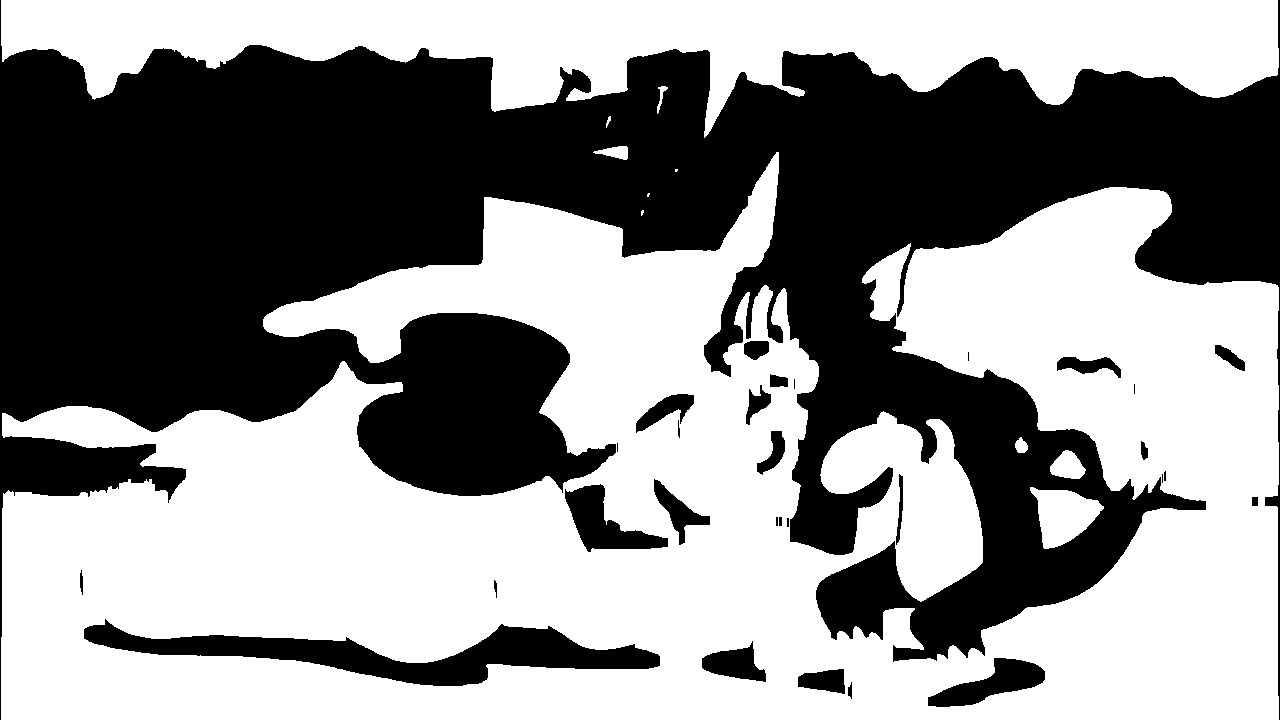

In [ ]:
# Noise removal
#closing_img = cv2.morphologyEx(thresh_img,cv2.MORPH_CLOSE, kernel, iterations = 4)
closing_img = cv2.morphologyEx(im_bw,cv2.MORPH_CLOSE, kernel, iterations = 4)

cv2_imshow(closing_img)

DISTANCE TRANSFORMATION

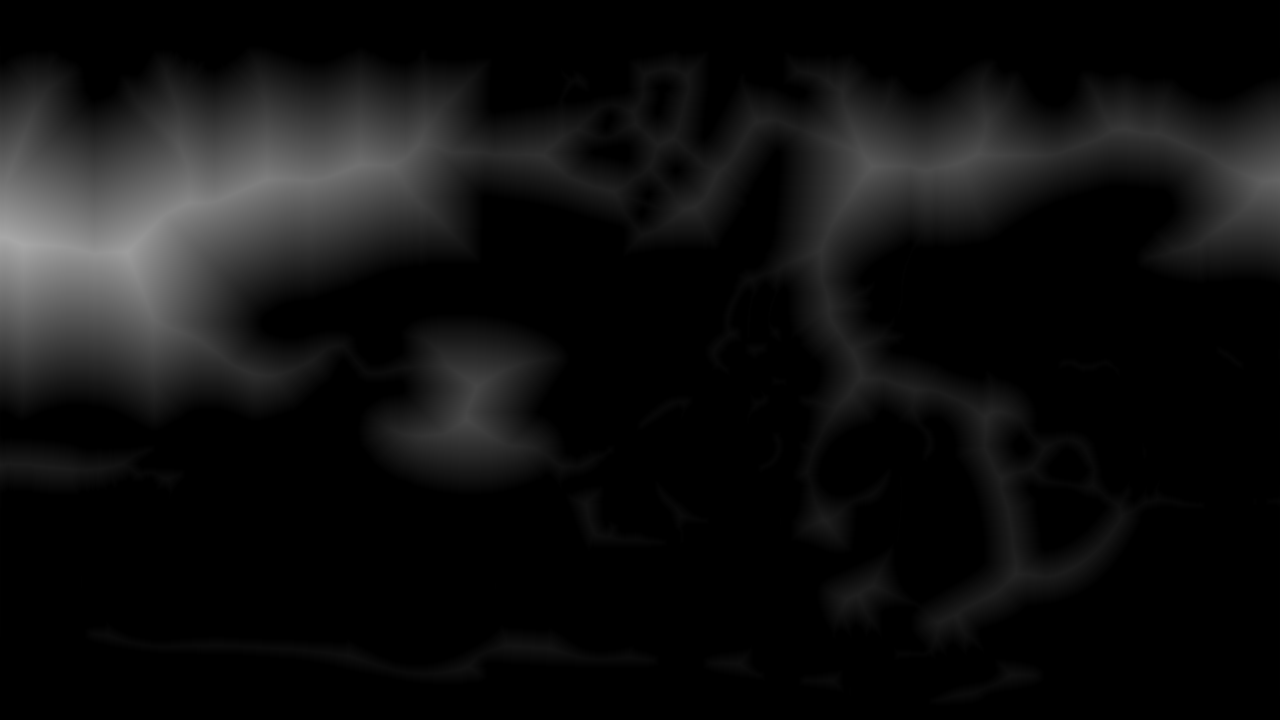

In [ ]:
dist_transform = cv2.distanceTransform(255 - closing_img, cv2.DIST_L2, 3)
cv2_imshow(dist_transform)

In [ ]:
local_max_location = peak_local_max(dist_transform, min_distance=1, indices=True)

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30)
kmeans.fit(local_max_location)
local_max_location = kmeans.cluster_centers_.copy()

In [ ]:
# Kmeans is returning a float data type so we need to convert it to an int. 
local_max_location = local_max_location.astype(int)


In [ ]:
local_max_location.shape
dist_transform_copy = dist_transform.copy()
for i in range(local_max_location.shape[0]):
  cv2.circle( dist_transform_copy, (local_max_location[i][1],local_max_location[i][0]  ), 5, 255)

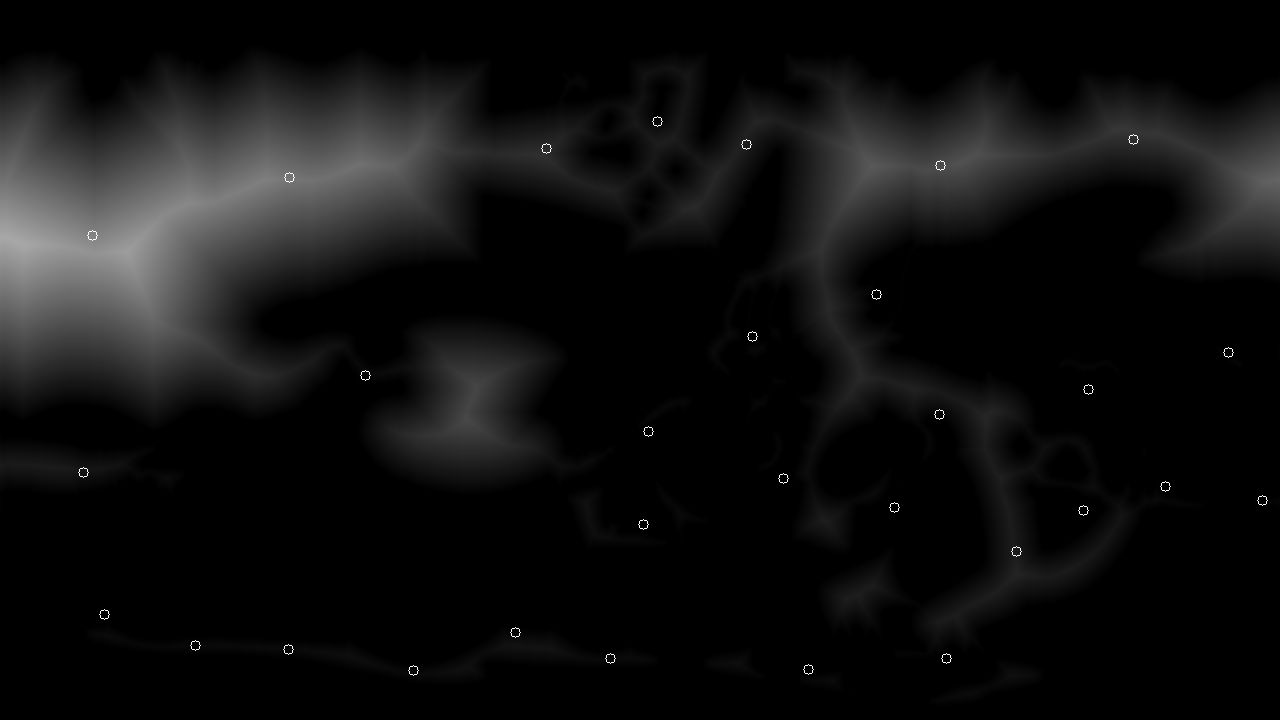

In [ ]:
cv2_imshow(dist_transform_copy)

In [ ]:
markers = np.zeros_like(dist_transform)
labels = np.arange(kmeans.n_clusters)
markers[local_max_location[:,0],local_max_location[:,1]   ] = labels + 1

In [ ]:
# Convert all local markers to an integer. This because cluster centers will be float numbers. 
markers = markers.astype(int)

In [ ]:
markers_copy = markers.copy()
index_non_zero_markers = np.argwhere(markers != 0)

In [ ]:
markers_copy = markers_copy.astype(np.uint8)

In [ ]:
index_non_zero_markers
font = cv2.FONT_HERSHEY_SIMPLEX
for i in range(index_non_zero_markers.shape[0]):
  string_text = str(markers[index_non_zero_markers[i][0] ,index_non_zero_markers[i][1]    ])
  cv2.putText( markers_copy, string_text, (index_non_zero_markers[i][1], index_non_zero_markers[i][0]), font, 1, 255)

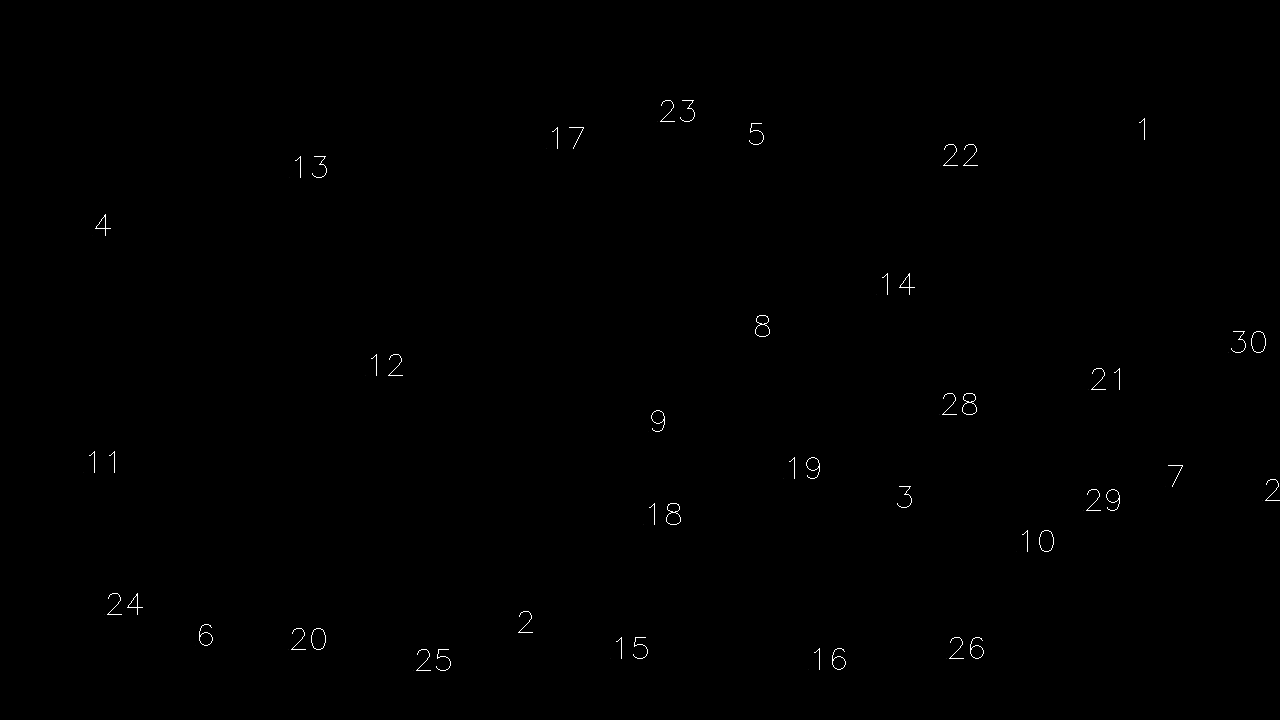

In [ ]:
cv2_imshow(markers_copy)

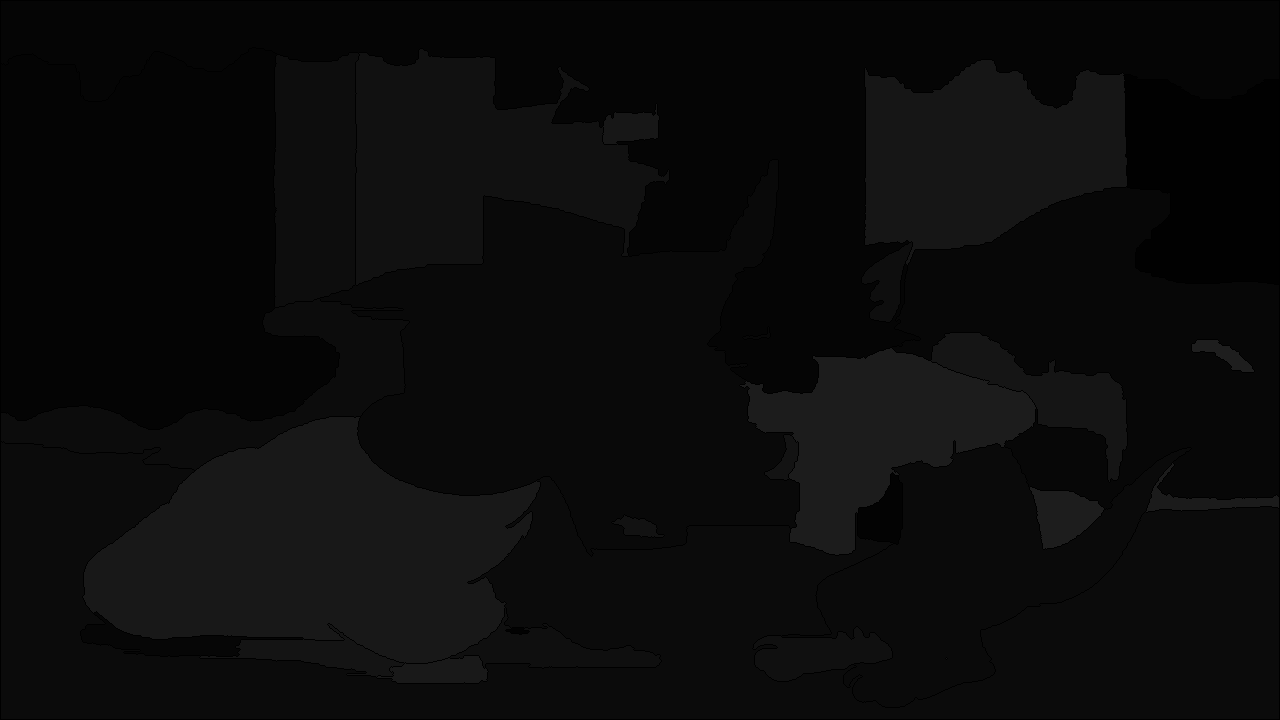

[[-1 -1 -1 ... -1 -1 -1]
 [-1  5  5 ...  5  5 -1]
 [-1  5  5 ...  5  5 -1]
 ...
 [-1 11 11 ... 11 11 -1]
 [-1 11 11 ... 11 11 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [ ]:
markers = markers.astype(np.int32)
segmented = cv2.watershed(img, markers)
cv2_imshow(segmented)
print(segmented)

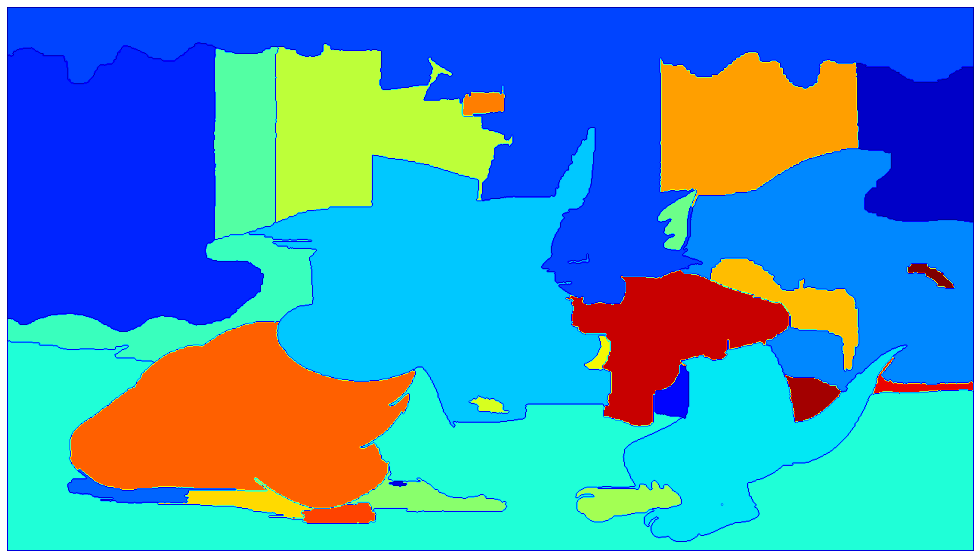

In [ ]:
dpi = plt.rcParams['figure.dpi']
figsize = img.shape[1] / float(dpi), img.shape[0] / float(dpi)

plt.figure(figsize=figsize)
plt.imshow(segmented, cmap="jet")
filename = "markers.jpg"
plt.axis('off')
plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
from PIL import Image

overlay = cv2.imread("markers.jpg")
overlay = np.asarray(overlay)

In [ ]:
img_copy = img.copy()
overlay_copy = overlay.copy()

In [ ]:
overlay_copy = cv2.resize(overlay_copy, (img_copy.shape[1], img_copy.shape[0]))
final_img = cv2.addWeighted(overlay_copy, 0.5, img_copy, 0.5,	0)

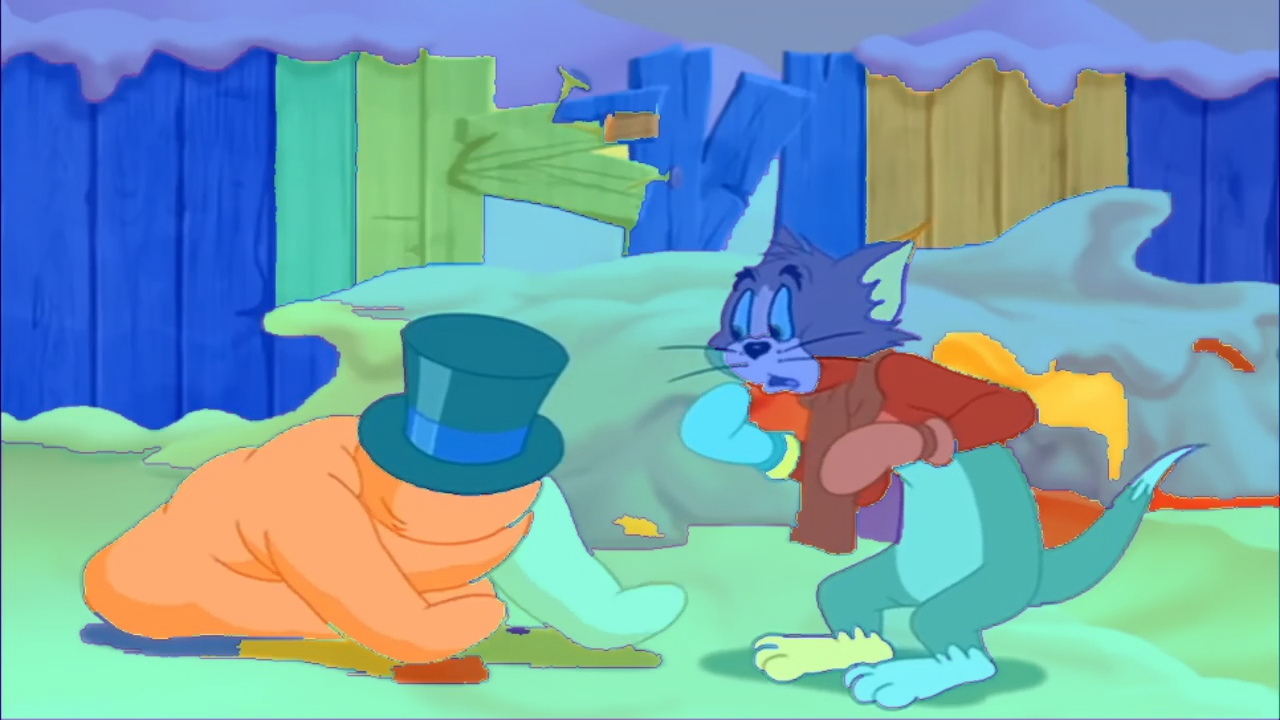

In [ ]:
cv2_imshow(final_img)

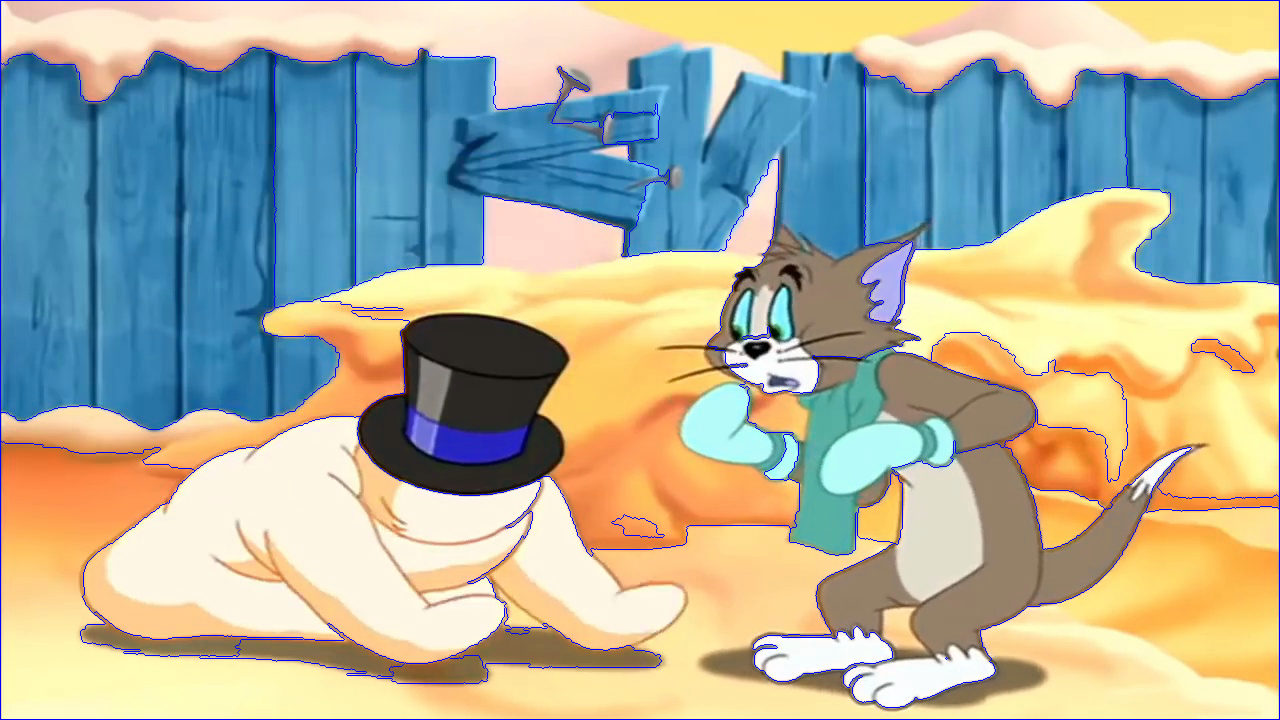

In [ ]:
img_c = img.copy() 
img_c[segmented == -1] = [255, 0, 0]
cv2_imshow(img_c)